# Creating the Figures for the Manuscript

### Date: 2025-03-26

# Setup

In [1]:
import warnings

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from metadata import simulation_num_to_name_mapping

/home/yann/miniconda3/envs/role_of_luck_3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=1.25)

In [4]:
# Useful Snippets

# Remove legend title
# fig.get_legend().set_title("")

# Remove "Model" from the end of each model name
# fig.legend(labels=[label.rstrip(" Model") for label in fig.get_legend_handles_labels()[1]], handles=fig.get_legend_handles_labels()[0])

# Legend bounding box location
# bbox_to_anchor=(0.5,-0.03) # when using lower center places it at the centre below the subplots with some extra space to not overlap with the axes

In [5]:
# I'm going to generate the figures from the datasets instead of the sim_populations, that way I don't have to run the sim_populations each time

### Loading the DataFrames of Simulation Data

In [6]:
sim_names = simulation_num_to_name_mapping.keys()

sim_populations = {}
sim_pop_over_time = {}
sim_cross_sectional = {}
sim_cross_sectional_zombie = {}

for sim_name in sim_names:
    temp_df = pd.read_csv(f"./results/simulation_datasets/{sim_name}/population.csv", index_col=0)
    sim_populations[sim_name] = temp_df

    temp_df = pd.read_csv(f"./results/simulation_datasets/{sim_name}/population_over_time.csv", index_col=0)
    sim_pop_over_time[sim_name] = temp_df


### Model Mortality for All Simulations 

In [7]:
sim_model_mortality = {}

for sim_name, population in sim_populations.items():
    model_mortality = population['age_of_death'].value_counts()

    for age in range(0, 81):
        if age not in model_mortality.index:
            model_mortality.loc[age] = 0

    model_mortality = model_mortality.reset_index(name='count').rename(columns={'age_of_death': 'age'})
    model_mortality = model_mortality.sort_values('age', ascending=False).set_index('age').cumsum().iloc[::-1]
    model_mortality = model_mortality.rename(columns={'count': 'Model survivors at age x'}).reset_index()

    sim_model_mortality[sim_name] = model_mortality

In [8]:
all_sims_mortality = pd.DataFrame()

for sim_name, mortality in sim_model_mortality.items():
    mortality['Model'] = sim_name
    all_sims_mortality = pd.concat([all_sims_mortality, mortality])    

In [9]:
# Changed the names of the models
sim_name_replacement = {
    'Mediumly correlated luck model': 'Medium correlated luck model',
    'Highly correlated luck model': 'High correlated luck model',
}

In [10]:
real_world_mortality = pd.read_csv("./luck_vs_circumstance/datasets/2019_Life_Table_data.csv", index_col=0)
real_world_mortality.rename(columns={'VALUE': 'Model survivors at age x', 'Age group': 'age'}, inplace=True)
real_world_mortality["Model"] = "2019 Canadian Empirical Data"
real_world_mortality['age'] = real_world_mortality.age.str.replace("\D+", "", regex=True).astype(int)
real_world_mortality = real_world_mortality[real_world_mortality.age <= 80]
real_world_mortality['Model survivors at age x'] = real_world_mortality['Model survivors at age x'] / 10
all_sims_mortality = pd.concat([all_sims_mortality, real_world_mortality])
all_sims_mortality['Model'] = all_sims_mortality['Model'].replace(sim_name_replacement).str.title()

# Figures

## Survival Curves 

/tmp/ipykernel_2455138/2174175710.py:12: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(data=all_sims_mortality, x='age', y='Model survivors at age x', hue='Model', ax=axs, palette=modified_palette)


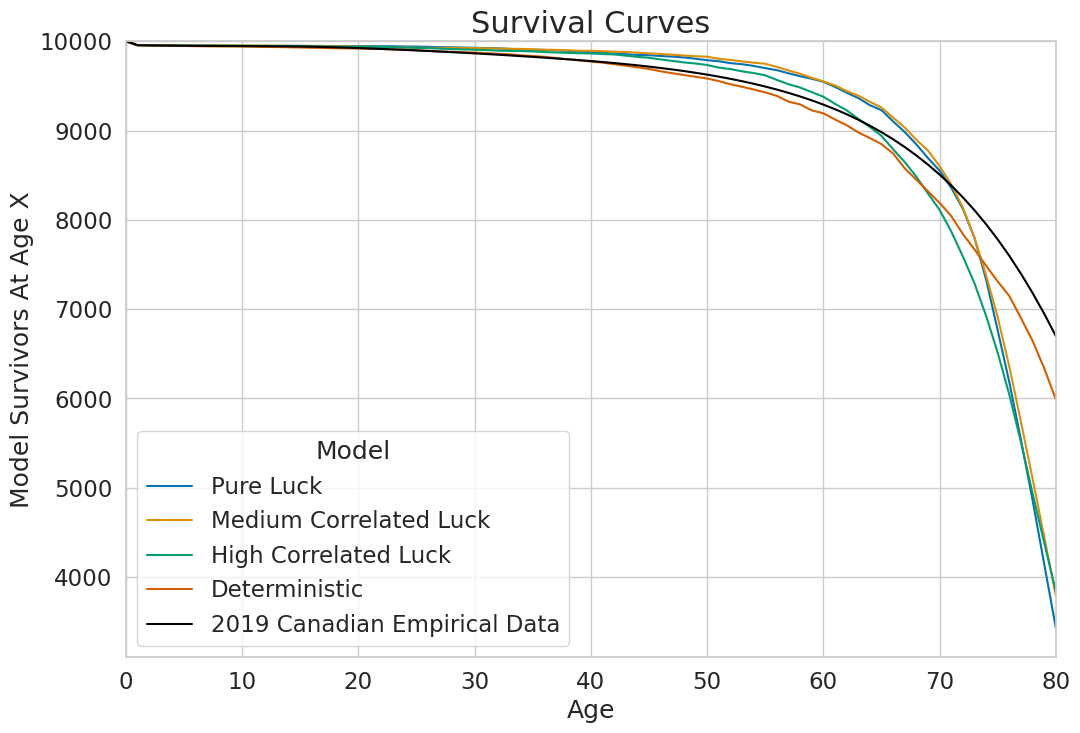

In [11]:
# Modified for diverging colors
# modified_palette = sns.diverging_palette(145, 300, s=60)
# modified_palette = [modified_palette[0], modified_palette[1], modified_palette[4], modified_palette[5], (0,0,0)]

# Modified to have the real world be black
modified_palette = list(sns.color_palette())
modified_palette[4] = (0,0,0)

sns.set_context("notebook", font_scale=1.5)

fig, axs = plt.subplots(figsize=(12,8))
sns.lineplot(data=all_sims_mortality, x='age', y='Model survivors at age x', hue='Model', ax=axs, palette=modified_palette)
axs.set_xlim(0, 80)
axs.set_ylim(top=10_000)
axs.legend(labels=[label.rstrip(" Model") for label in axs.get_legend_handles_labels()[1]], handles=axs.get_legend_handles_labels()[0])
axs.get_legend().set_title("Model")
axs.set_ylabel(axs.get_ylabel().title())# , fontsize=14)
axs.set_xlabel(axs.get_xlabel().title())# , fontsize=14)
axs.set_title("Survival Curves", fontsize=22) # , fontsize=18)

fig.savefig("./figures/manuscript_figures/Figure_1.png", dpi=600, bbox_inches='tight')

## Survival Curves by Effort and Circumstance

In [12]:
sns.set_context("notebook", font_scale=1.25)

In [13]:
import matplotlib

def plot_inequity_mortality_curves(population, c_or_e: str, index=None, number_of_years=80, normalize_e=False):
    population = population.copy()
    # population_over_time = lvc_model.population_over_time.copy()

    if c_or_e == "c":
        min_pop = population[population.circumstance_score == population.circumstance_score.min()]
        max_pop = population[population.circumstance_score == population.circumstance_score.max()]
        mid_pop = population[population.circumstance_score == population.circumstance_score.median()]
    elif c_or_e == "e" and normalize_e == False:
        population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, 0.1, 0.45, 0.55, 0.9, 1.0])
        min_pop = population[population.effort_quantiles == population.effort_quantiles.min()]
        max_pop = population[population.effort_quantiles == population.effort_quantiles.max()]
        mid_pop = population[population.effort_quantiles == sorted(population.effort_quantiles.unique())[2]] 
    elif c_or_e == "e" and normalize_e == True:
        cdv = population.circumstance_score.value_counts(normalize=True).sort_index()
        population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, cdv.iloc[0], 0.5 - (cdv.iloc[3] / 2), 0.5 + (cdv.iloc[3] / 2), 1.0 - cdv.iloc[6], 1.0])
        min_pop = population[population.effort_quantiles == population.effort_quantiles.min()]
        max_pop = population[population.effort_quantiles == population.effort_quantiles.max()]
        mid_pop = population[population.effort_quantiles == sorted(population.effort_quantiles.unique())[2]]
    else:
        raise ValueError("c_or_e must be 'c' or 'e'")

    sub_pop_model_mortalities = []

    for sub_pop in (population, min_pop, max_pop, mid_pop):   
        model_mortality = sub_pop['age_of_death'].value_counts(normalize=True)

        # Added the plus one to the number of years as this fixes a reshaping bug 
        # that occurs when everyone is dead before the end of the timeline
        for age in range(0, number_of_years + 1):
            if age not in model_mortality.index:
                model_mortality.loc[age] = 0

        model_mortality = model_mortality.reset_index(name='count').rename(columns={'age_of_death': 'age'})
        model_mortality = model_mortality.sort_values('age', ascending=False).set_index('age').cumsum().iloc[::-1]
        model_mortality = model_mortality.rename(columns={'count': 'Model survivors at age x'}).reset_index()
        model_mortality['Model survivors at age x'] = model_mortality['Model survivors at age x'] * 100
        model_mortality = model_mortality

        sub_pop_model_mortalities.append(model_mortality)

    population_mortality, min_pop_mortality, max_pop_mortality, mid_pop_mortality = sub_pop_model_mortalities

    # cmap = matplotlib.cm.get_cmap("tab10").colors
    cmap = sns.color_palette('flare', n_colors=9)
    # Plotting the mortality data
    fig, ax1 = plt.subplots()
    # ax1.plot(real_data[:, 1], "-", label="Real Survivors", color=cmap[1])
    # ax1.plot(model_data[:, 1], "--", label="Model Survivors", color=cmap[2])
    # ax1.plot(base_model_mortality[:, 1], ':', label="Base Model Survivors", color=cmap[3])

    score_str = "Circumstance" if c_or_e == "c" else "Effort"

    # if c_or_e == 'c':
    #     ax1.plot(population_mortality.iloc[:, 1], '-', label="All Survivors", color=cmap[0])
    #     ax1.plot(min_pop_mortality.iloc[:, 1], '--', label=f"Min Value", color=cmap[1])
    #     ax1.plot(mid_pop_mortality.iloc[:, 1], '-.', label=f"Median Value", color=cmap[2])
    #     ax1.plot(max_pop_mortality.iloc[:, 1], ':', label=f"Max Value", color=cmap[3])
    # else:
    #     ax1.plot(population_mortality.iloc[:, 1], '-', label="All Survivors", color=cmap[0])
    #     ax1.plot(min_pop_mortality.iloc[:, 1], '--', label=f"Min Decile", color=cmap[1])
    #     ax1.plot(mid_pop_mortality.iloc[:, 1], '-.', label=f"Median Decile", color=cmap[2])
    #     ax1.plot(max_pop_mortality.iloc[:, 1], ':', label=f"Max Decile", color=cmap[3])

    if c_or_e == 'c':
        # ax1.plot(population_mortality.iloc[:, 1], label="All Survivors", color=cmap[0])
        ax1.plot(min_pop_mortality.iloc[:, 1], label=f"Mininum Circumstance", color=cmap[0])
        ax1.plot(mid_pop_mortality.iloc[:, 1], label=f"Median Circumstance", color=cmap[3])
        ax1.plot(max_pop_mortality.iloc[:, 1], label=f"Maximum Circumstance", color=cmap[8])
    else:
        # ax1.plot(population_mortality.iloc[:, 1], label="All Survivors", color=cmap[0])
        ax1.plot(min_pop_mortality.iloc[:, 1], label=f"Mininum Effort", color=cmap[0])
        ax1.plot(mid_pop_mortality.iloc[:, 1], label=f"Median Effort", color=cmap[3])
        ax1.plot(max_pop_mortality.iloc[:, 1], label=f"Maximum Effort", color=cmap[8])

    # ax1.plot(population_mortality.iloc[:, 1], label="All Survivors", color=cmap[1])
    # ax1.plot(min_pop_mortality.iloc[:, 1], label=f"Min", color=cmap[2])
    # ax1.plot(mid_pop_mortality.iloc[:, 1], label=f"Median", color=cmap[4])
    # ax1.plot(max_pop_mortality.iloc[:, 1], label=f"Max", color=cmap[3])

    # Adding some labels and title
    ax1.set_ylabel("Percentage of Survivors")# , fontsize=11)
    ax1.set_xlabel("Age") # , fontsize=11)
    ax1.set_title(f"Survival Curves by {score_str}") # , fontsize=13)
    ax1.legend(loc='lower left', title="")

    fig.tight_layout()
    ax1.set_xlim(0, 80)
    ax1.set_ylim(top=100, bottom=0)

    return fig

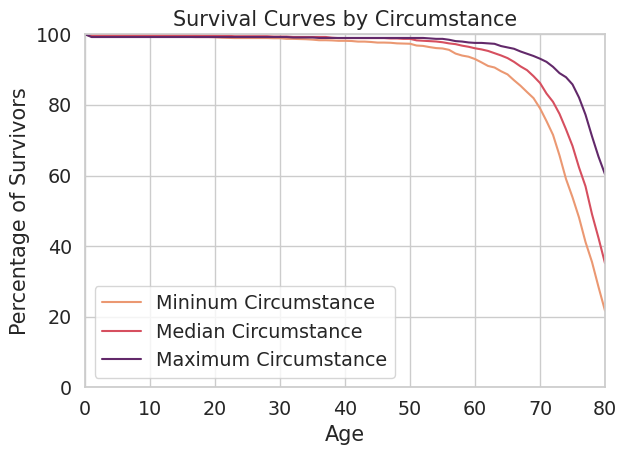

In [14]:
fig = plot_inequity_mortality_curves(sim_populations['Mediumly correlated luck model'], 'c')
fig.show()

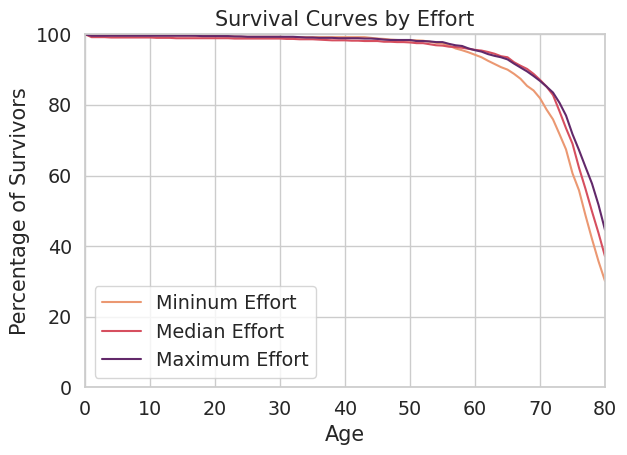

In [15]:
fig = plot_inequity_mortality_curves(sim_populations['Mediumly correlated luck model'], 'e', normalize_e=False)
fig.show()

In [16]:

def plot_inequity_mortality_curves_for_all_simulations(sim_populations, c_or_e: str, index=None, number_of_years=80, normalize_e=False):

    shape = (2,2)

    fig, ax1 = plt.subplots(*shape, figsize=(12, 8))
    for i, (sim, population) in enumerate(sim_populations.items()):
        # print(sim)
        # if sim == "Pure luck model" and c_or_e == 'e':
        #     continue
        population = population.copy()

        row, col = np.unravel_index(i, shape)
        # population_over_time = lvc_model.population_over_time.copy()

        if c_or_e == "c":
            min_pop = population[population.circumstance_score == population.circumstance_score.min()]
            max_pop = population[population.circumstance_score == population.circumstance_score.max()]
            mid_pop = population[population.circumstance_score == population.circumstance_score.median()]
        elif c_or_e == "e" and normalize_e == False and sim != 'Pure luck model':
            population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, 0.1, 0.45, 0.55, 0.9, 1.0])
            min_pop = population[population.effort_quantiles == population.effort_quantiles.min()]
            max_pop = population[population.effort_quantiles == population.effort_quantiles.max()]
            mid_pop = population[population.effort_quantiles == sorted(population.effort_quantiles.unique())[2]] 
        elif c_or_e == "e" and normalize_e == False and sim == 'Pure luck model':
            # population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, 0.1, 0.45, 0.55, 0.9, 1.0])
            min_pop = population
            max_pop = population
            mid_pop = population
        elif c_or_e == "e" and normalize_e == True:
            cdv = population.circumstance_score.value_counts(normalize=True).sort_index()
            population['effort_quantiles'] = pd.qcut(population.effort_score, q=[0, cdv.iloc[0], 0.5 - (cdv.iloc[3] / 2), 0.5 + (cdv.iloc[3] / 2), 1.0 - cdv.iloc[6], 1.0])
            min_pop = population[population.effort_quantiles == population.effort_quantiles.min()]
            max_pop = population[population.effort_quantiles == population.effort_quantiles.max()]
            mid_pop = population[population.effort_quantiles == sorted(population.effort_quantiles.unique())[2]]
        else:
            raise ValueError("c_or_e must be 'c' or 'e'")

        sub_pop_model_mortalities = []

        for sub_pop in (population, min_pop, max_pop, mid_pop):   
            model_mortality = sub_pop['age_of_death'].value_counts(normalize=True)

            # Added the plus one to the number of years as this fixes a reshaping bug 
            # that occurs when everyone is dead before the end of the timeline
            for age in range(0, number_of_years + 1):
                if age not in model_mortality.index:
                    model_mortality.loc[age] = 0

            model_mortality = model_mortality.reset_index(name='count').rename(columns={'age_of_death': 'age'})
            model_mortality = model_mortality.sort_values('age', ascending=False).set_index('age').cumsum().iloc[::-1]
            model_mortality = model_mortality.rename(columns={'count': 'Model survivors at age x'}).reset_index()
            model_mortality['Model survivors at age x'] = model_mortality['Model survivors at age x'] * 100
            model_mortality = model_mortality

            sub_pop_model_mortalities.append(model_mortality)

        population_mortality, min_pop_mortality, max_pop_mortality, mid_pop_mortality = sub_pop_model_mortalities

        # cmap = matplotlib.cm.get_cmap("tab10").colors
        cmap = sns.color_palette('flare', n_colors=9)
        # Plotting the mortality data

        score_str = "Circumstance" if c_or_e == "c" else "Effort"

        if c_or_e == 'c':
            # ax1.plot(population_mortality.iloc[:, 1], label="All Survivors", color=cmap[0])
            ax1[row, col].plot(min_pop_mortality.iloc[:, 1], label=f"Mininum Circumstance", color=cmap[0])
            ax1[row, col].plot(mid_pop_mortality.iloc[:, 1], label=f"Median Circumstance", color=cmap[3])
            ax1[row, col].plot(max_pop_mortality.iloc[:, 1], label=f"Maximum Circumstance", color=cmap[8])
        else:
            # ax1.plot(population_mortality.iloc[:, 1], label="All Survivors", color=cmap[0])
            ax1[row, col].plot(min_pop_mortality.iloc[:, 1], label=f"Mininum Effort", color=cmap[0])
            ax1[row, col].plot(mid_pop_mortality.iloc[:, 1], label=f"Median Effort", color=cmap[3])
            ax1[row, col].plot(max_pop_mortality.iloc[:, 1], label=f"Maximum Effort", color=cmap[8])

        # Adding some labels and title
        ax1[row, col].set_ylabel("Percentage of Survivors")# , fontsize=11)
        ax1[row, col].set_xlabel("Age") # , fontsize=11)
        ax1[row, col].set_title(f"{sim.replace('ly', '').title().rstrip(' Model')}") # , fontsize=13)
        # ax1[row, col].legend(loc='lower left', title="")
        ax1[row, col].legend().remove()
        ax1[row, col].set_xlim(0, 80)
        ax1[row, col].set_ylim(top=100, bottom=0)

    fig.legend(labels=[label for label in ax1[0,0].get_legend_handles_labels()[1]], handles=ax1[0,0].get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.05), ncol=4, title='', fontsize=13).get_frame().set_linewidth(0.0) #, fontsize=12, title_fontsize=12)
    # leg = fig.get_legend()
    # fig.legend().get_frame().set_linewidth(0.0)

    fig.suptitle(f"Survival Curves by {score_str}")

    fig.tight_layout()

    return fig

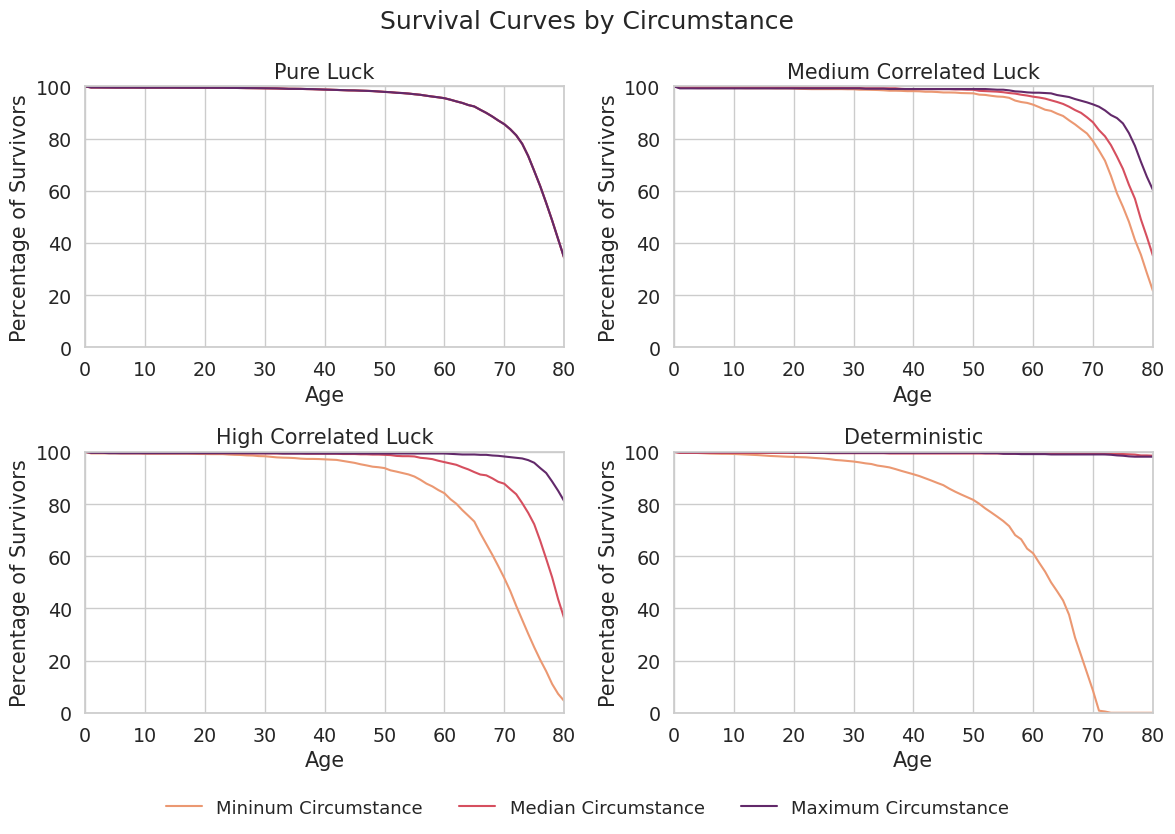

In [17]:
fig = plot_inequity_mortality_curves_for_all_simulations(sim_populations, c_or_e='c')
fig.show()

fig.savefig("./figures/appendix_figures/Appendix_8.png", dpi=600, bbox_inches='tight')

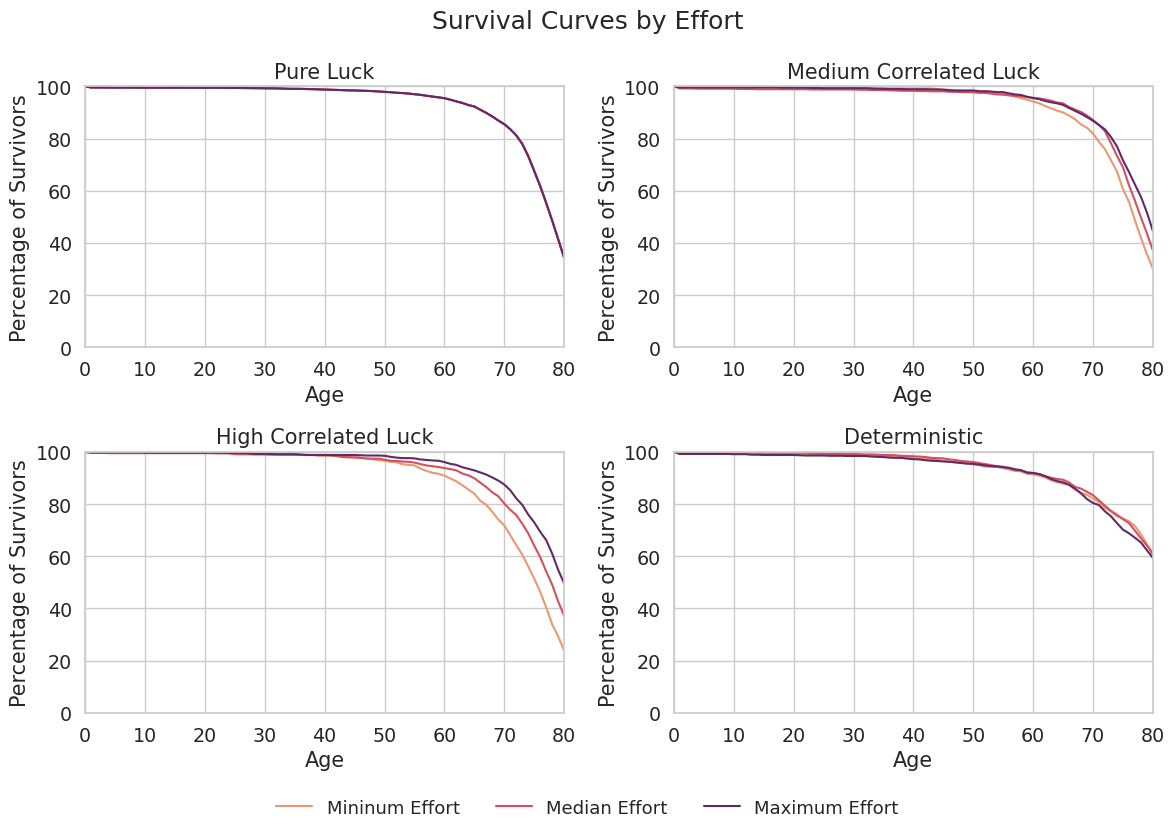

In [18]:
fig = plot_inequity_mortality_curves_for_all_simulations(sim_populations, c_or_e='e')
fig.show()

## Population Surviving to Age 80

In [19]:
from luck_vs_circumstance import dist, params

def plot_proportion_of_deaths_by_circumstance_score(sim_populations):
    prop_frame = pd.DataFrame()

    plt.figure(figsize=(12,8))

    for sim_num in sim_populations.keys():
        if sim_num == "Pure luck model":
            # Adding imaginary noise to simulation 0
            canada_education, _, _ = params.parse_empirical_data("/home/yann/health_inequity_simulation/luck_vs_circumstance/datasets")
            c_dist = dist.Circumstance_Distribution(canada_education['Circumstance_Score'], canada_education['Proportion'])
            population = sim_populations[sim_num].copy()
            population['circumstance_score'] = c_dist.draw(10000)
        else:
            population = sim_populations[sim_num].copy()

        # population = population[~population.cause_of_death.isin(['accidental', 'neonatal'])]
        temp = population.groupby('circumstance_score').age_of_death.value_counts(True).to_frame().reset_index()
        subtemp = temp[temp.age_of_death == 80].copy()
        for c in population.circumstance_score.unique():
            if c not in subtemp.circumstance_score.unique():
                subtemp = pd.concat([subtemp, pd.DataFrame({'circumstance_score': c, 'age_of_death': 80, 'proportion': 0}, index=[0])])
        subtemp = subtemp.sort_values('circumstance_score')
        subtemp['simulation'] = str(sim_num)
        prop_frame = pd.concat([prop_frame, subtemp])
        prop_frame['simulation'] = prop_frame.simulation.replace(sim_name_replacement).str.title()
        # sns.lineplot(subtemp, x='circumstance_score', y='proportion', label=sim_num).set_title("Proportion of Agents surviving to age 80 by Circumstance")

    prop_frame['proportion'] = prop_frame['proportion'] * 100
    fig = sns.lineplot(data=prop_frame, x='circumstance_score', y='proportion', hue='simulation', marker='o', markersize=8)# , title="Proportion of Agents surviving to age 80 by Circumstance")

    return fig

<frozen importlib._bootstrap>:241: RuntimeWarning: neworder installed in serial mode. If necessary, enable MPI with: pip install neworder[parallel]


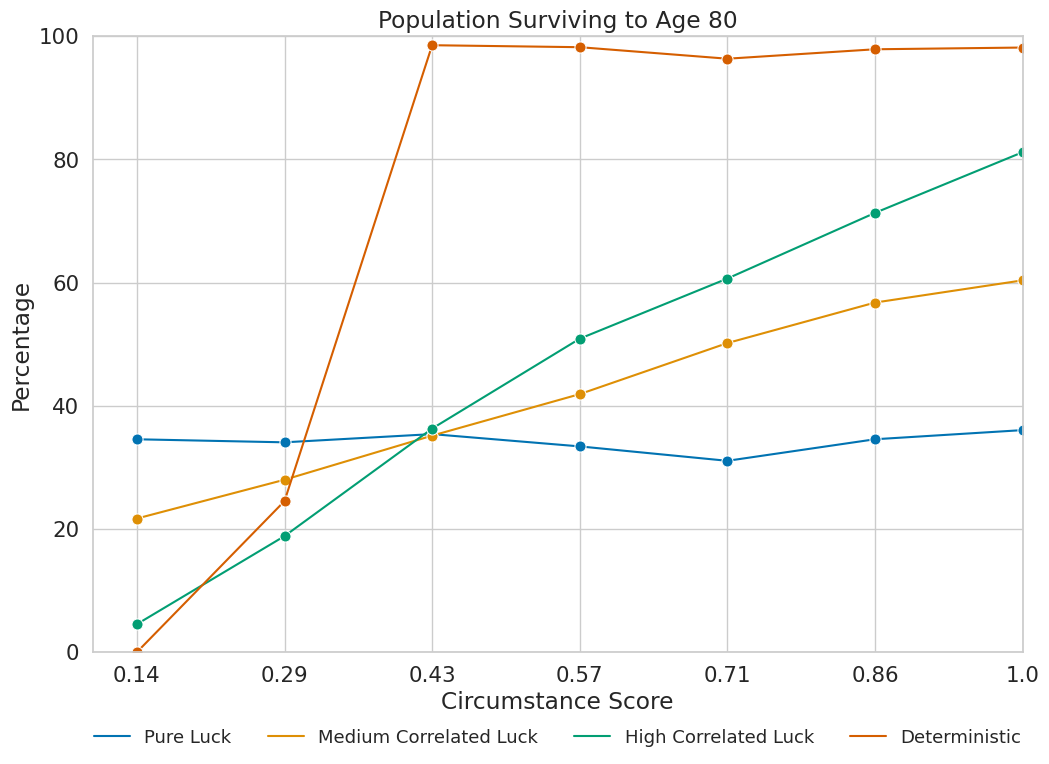

In [20]:
sns.set_context("notebook", font_scale=1.4)

fig = plot_proportion_of_deaths_by_circumstance_score(sim_populations)
fig.set_xlabel("Circumstance Score") #, fontsize=12)
fig.set_ylabel("Percentage") #, fontsize=12)
fig.set_title("Population Surviving to Age 80") #, fontsize=14)
fig.set_xlim(right=1)
fig.set_ylim(top=100, bottom=0)
fig.set_xticks(sorted(sim_populations['Deterministic model'].circumstance_score.unique()), labels=[0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.00])
# fig.legend(labels=[label.rstrip(" Model") for label in fig.get_legend_handles_labels()[1]], handles=fig.get_legend_handles_labels()[0], title='Model')
fig.legend(labels=[label.rstrip(" Model") for label in fig.get_legend_handles_labels()[1]], handles=fig.get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.18), ncol=4, title='', fontsize=13) #, fontsize=12, title_fontsize=12)
leg = fig.get_legend()
leg.get_frame().set_linewidth(0.0)

plt.savefig("./figures/manuscript_figures/Figure_4.png", dpi=600, bbox_inches='tight')

## Loading the Data from Excel files

In [21]:
sns.set_context("notebook", font_scale=1.5)

### Loading the Gini Analysis Data from the Excel File

In [24]:
dataset = "./Gini_lifecourse_cross-sectional_31JAN2025.xlsx"

#### Life Course Gini Graph Sheet Data

In [26]:
gini_life_course_df = pd.read_excel(dataset, sheet_name="life course Gini graph")

In [27]:
gini_life_course_df = gini_life_course_df.dropna(how='all').iloc[1:]

In [28]:
gini_life_course_df = gini_life_course_df.rename(columns={'This corresponds to Figure R2 & Figure R3': 'Analysis', 'Unnamed: 1': 'Method', 'Unnamed: 2': 'Model', 'Unnamed: 3': 20, 'Unnamed: 4': 40, 'Unnamed: 5': 60, 'Unnamed: 6': 80,})

In [29]:
gini_life_course_df = gini_life_course_df.reset_index().drop(columns='index')

In [30]:
name_replacement = {0: 'Pure Luck Model', 4: 'Medium Correlated Luck Model', 9: 'High Correlated Luck Model', 12: 'Deterministic Model'}

In [31]:
gini_life_course_df['Model'] = gini_life_course_df.Model.replace(name_replacement)

In [32]:
gini_df = gini_life_course_df.iloc[:17]
percent_dead_df = gini_life_course_df.iloc[17:22]
below_point_five_df = gini_life_course_df[22:]

#### Gini Graph Data

In [33]:
gini_df = gini_df[gini_df.Model != 'Model'].copy()

In [34]:
gini_df['Analysis'] = gini_df.Analysis.fillna(method='ffill')
gini_df['Method'] = gini_df.Method.fillna(method='ffill', limit=3)

In [35]:
gini_df = gini_df.melt(id_vars=['Analysis', 'Method', 'Model'], value_vars=[20, 40, 60, 80])

#### Percent Dead Data

In [36]:
percent_dead_df = percent_dead_df.iloc[1:]

In [37]:
percent_dead_df = percent_dead_df.drop(columns=['Analysis', 'Method'])

In [38]:
percent_dead_df = percent_dead_df.melt(id_vars=['Model'], value_vars=[20, 40, 60, 80])

In [39]:
percent_dead_df['Model'] = percent_dead_df.Model.replace(name_replacement)

#### % Below 0.5 Data

In [40]:
below_point_five_df = below_point_five_df.iloc[1:].copy()

In [41]:
below_point_five_df['Analysis'] = below_point_five_df.Analysis.fillna(method='ffill')

In [42]:
below_point_five_df = below_point_five_df.drop(columns='Method').rename(columns={'Analysis': 'Method'})

In [43]:
below_point_five_df = below_point_five_df[below_point_five_df.Model != 'Model'].copy()

In [44]:
below_point_five_df = below_point_five_df.melt(id_vars=['Method', 'Model'], value_vars=[20, 40, 60, 80])

In [45]:
below_point_five_df['Model'] = below_point_five_df.Model.replace(name_replacement)

## Gini Life-course

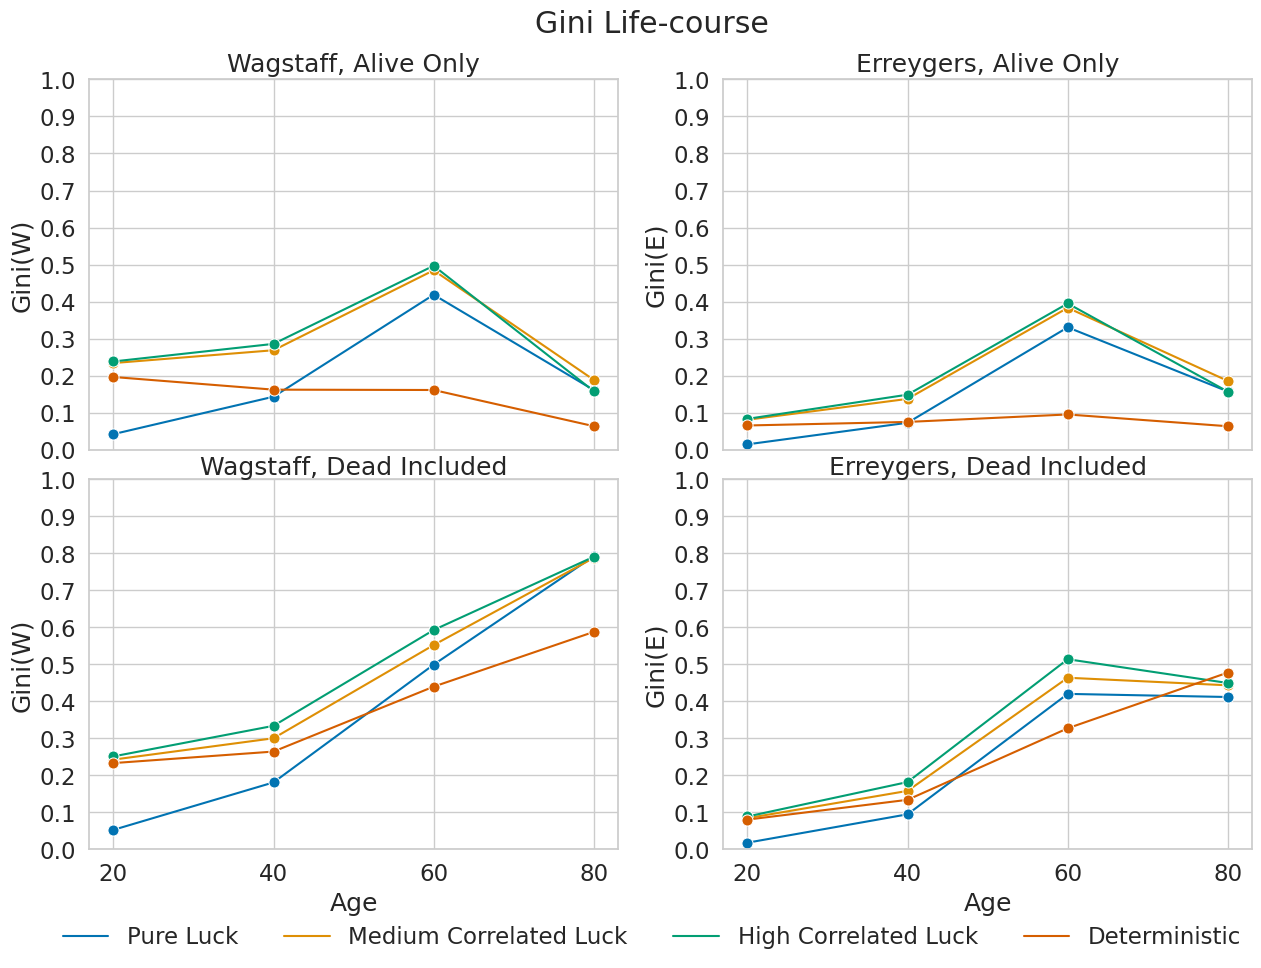

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

plt.setp(axs, xticks=[20,40,60,80], yticks=np.arange(0, 1.1, 0.1), ylim=(0,1))

for i, (method, analysis) in enumerate([('W', 'Alive only'), ('E', 'Alive only'), ('W', 'Dead included'), ('E', 'Dead included')]):
    row, col = np.unravel_index(i, (2, 2))
    sns.lineplot(data=gini_df[(gini_df.Method == method) & (gini_df.Analysis == analysis)], hue='Model', x='variable', y='value', marker='o', ax=axs[row, col], markersize=8)
    m = "Wagstaff" if method == "W" else "Erreygers"
    if i >= 2:
        axs[row, col].set_title(f"{m}, {analysis.title()}", pad=-16) #, fontsize=14)
        axs[row, col].set_xlabel("Age") #, fontsize=12)
    else:
        axs[row, col].set_title(f"{m}, {analysis.title()}") # , fontsize=14)
        axs[row, col].set_xlabel("")
        axs[row, col].set_xticklabels([])
    axs[row, col].set_ylabel(f"Gini({method})") #, fontsize=12)
    legend = axs[row, col].legend()
    axs[row, col].legend().remove()

fig.suptitle("Gini Life-course", y=0.95) #, fontsize=18)
fig.legend(labels=[label.rstrip(" Model") for label in axs[0,0].get_legend_handles_labels()[1]], handles=axs[0,0].get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.01), ncol=4, title='').get_frame().set_linewidth(0.0) # , fontsize=12, title_fontsize=12).get_frame().set_linewidth(0.0)
fig.subplots_adjust(hspace=0.08)
# axs[0,0].legend()
# fig.legend(*axs[0, 0].get_legend_handles_labels(), loc="upper right")
# fig.legend(labels=['Pure Luck Model', 'Mediumly correlated Luck Model'])

fig.savefig("./figures/manuscript_figures/Figure_2.png", dpi=600, bbox_inches='tight')

## % Below 0.5

In [47]:
sns.set_context("notebook", font_scale=1.25)

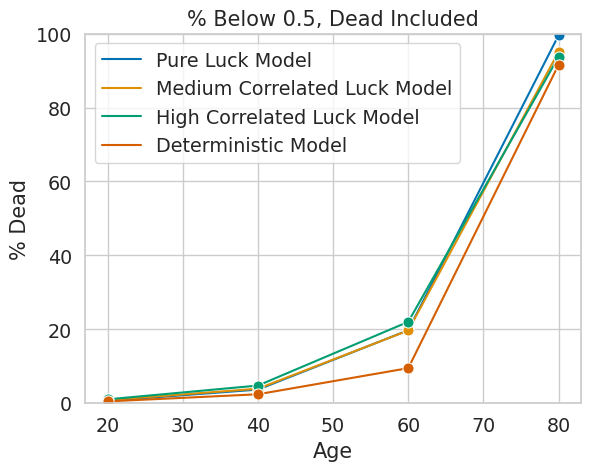

In [48]:
fig = sns.lineplot(data=below_point_five_df[(below_point_five_df['Method'] == 'dead included')], hue='Model', x='variable', y='value', marker='o', markersize=8)
plt.title("% Below 0.5, Dead Included")
plt.xlabel("Age")
plt.ylabel("% Dead")
fig.set_ylim(bottom=0, top=100)

fig.get_legend().set_title("")

(0.0, 100.0)

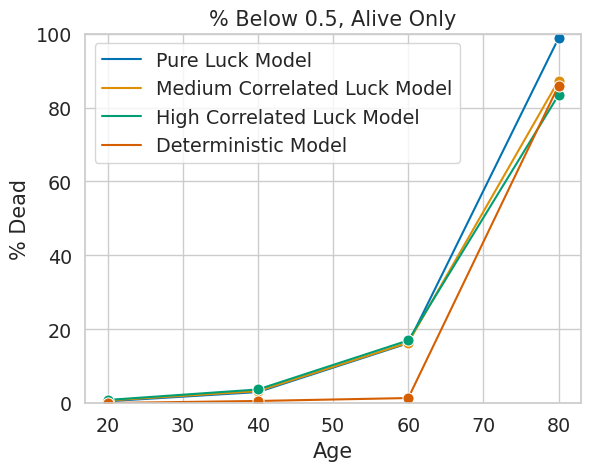

In [49]:
fig = sns.lineplot(data=below_point_five_df[(below_point_five_df['Method'] == 'alive only')], hue='Model', x='variable', y='value', marker='o', markersize=8)
plt.title("% Below 0.5, Alive Only")
plt.xlabel("Age") #, fontsize=12)
plt.ylabel("% Dead") #, fontsize=12)
fig.get_legend().set_title("")
fig.set_ylim(bottom=0, top=100)

## Health Score Below 0.5

In [50]:
sns.set_context("notebook", font_scale=1.4)

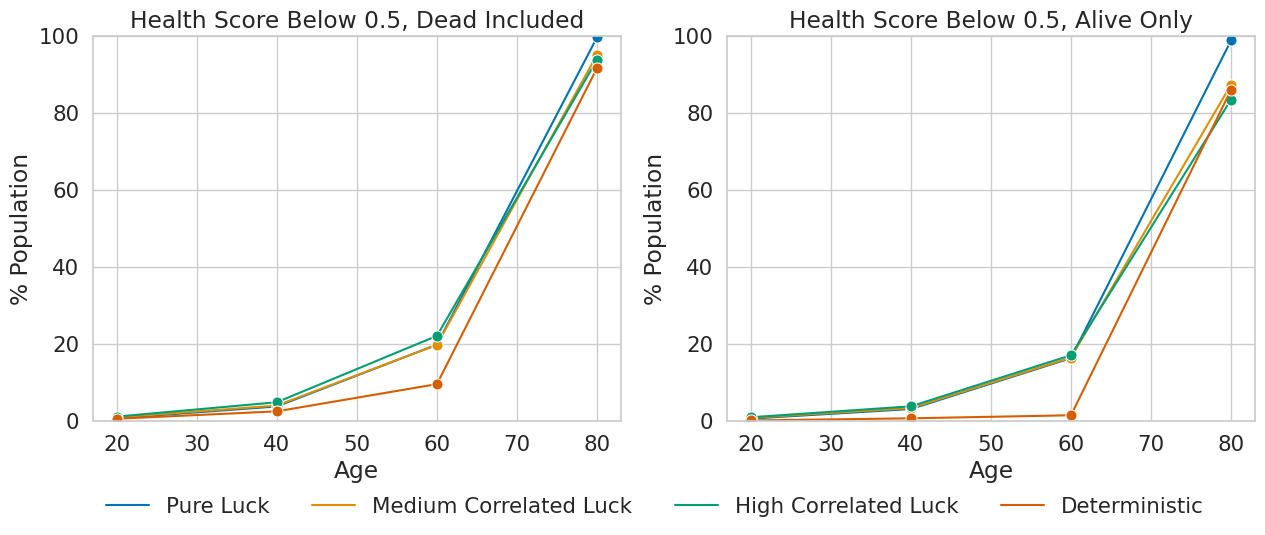

In [51]:
# Combining the two
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(data=below_point_five_df[(below_point_five_df['Method'] == 'dead included')], hue='Model', x='variable', y='value', marker='o', markersize=8, ax=axs[0])
axs[0].set_title("Health Score Below 0.5, Dead Included") # , fontsize=14)
axs[0].set_xlabel("Age") #, fontsize=12)
axs[0].set_ylabel("% Population") #, fontsize=12)
axs[0].set_ylim(bottom=0, top=100)
axs[0].get_legend().remove()

# axs[0].get_legend().set_title("")

sns.lineplot(data=below_point_five_df[(below_point_five_df['Method'] == 'alive only')], hue='Model', x='variable', y='value', marker='o', markersize=8, ax=axs[1])
axs[1].set_title("Health Score Below 0.5, Alive Only") #, fontsize=14)
axs[1].set_xlabel("Age") #, fontsize=12)
axs[1].set_ylabel("% Population") # , fontsize=12)
axs[1].get_legend().remove()
axs[1].set_ylim(bottom=0, top=100)

fig.legend(labels=[label.rstrip(" Model") for label in axs[0].get_legend_handles_labels()[1]], handles=axs[0].get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.12), ncol=4, title='').get_frame().set_linewidth(0.0) #, fontsize=12, title_fontsize=12).get_frame().set_linewidth(0.0)

fig.savefig("./figures/appendix_figures/Appendix_7.png", dpi=600, bbox_inches='tight')

## Model Deaths

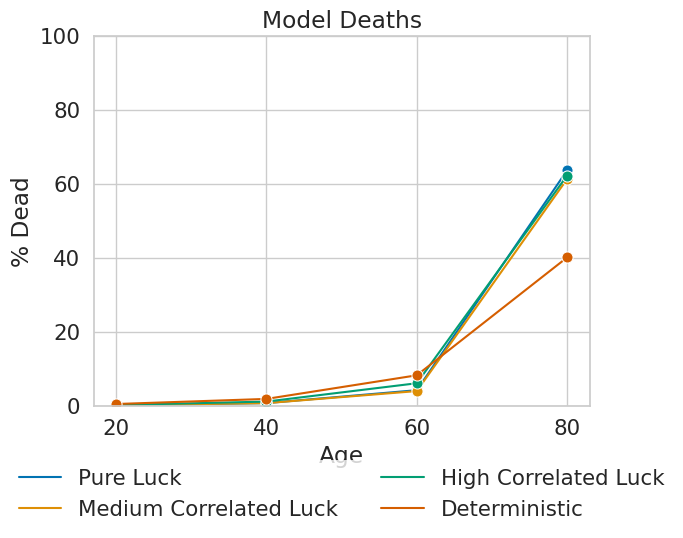

In [52]:
fig = sns.lineplot(data=percent_dead_df, hue='Model', x='variable', y='value', marker='o', markersize=8)
plt.xticks(ticks=[20,40,60,80])
plt.ylim(0,100)
# plt.legend()
plt.xlabel("Age") # , fontsize=12)
plt.ylabel("% Dead") #, fontsize=12)
plt.title("Model Deaths") #, fontsize=14)
fig.legend(labels=[label.rstrip(" Model") for label in fig.get_legend_handles_labels()[1]], handles=fig.get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.36), ncol=2, title='').get_frame().set_linewidth(0.0)
# fig.get_legend().set_title("")

plt.savefig("./figures/appendix_figures/Appendix_6.png", dpi=600, bbox_inches='tight')

## Concentration Index Life-course

In [53]:
life_course_ci_df = pd.read_excel(dataset, sheet_name="life course CI graph")

In [54]:
life_course_ci_df = life_course_ci_df.dropna(how='all')

In [55]:
life_course_ci_df = life_course_ci_df.rename(columns={'This corresponds to Figure R4': 'Analysis', 'Unnamed: 1': 'Method', 'Unnamed: 2': 'Model', 'Unnamed: 3': 20, 'Unnamed: 4': 40, 'Unnamed: 5': 60, 'Unnamed: 6': 80,})
life_course_ci_df = life_course_ci_df[life_course_ci_df.Model != 'Model'].copy()
life_course_ci_df = life_course_ci_df.iloc[1:]
life_course_ci_df['Analysis'] = life_course_ci_df.Analysis.fillna(method='ffill')
life_course_ci_df['Method'] = life_course_ci_df.Method.fillna(method='ffill')

In [56]:
life_course_ci_df = life_course_ci_df.melt(id_vars=['Analysis', 'Method', 'Model'], value_vars=[20, 40, 60, 80])

In [57]:
life_course_ci_df['Model'] = life_course_ci_df.Model.replace(name_replacement)

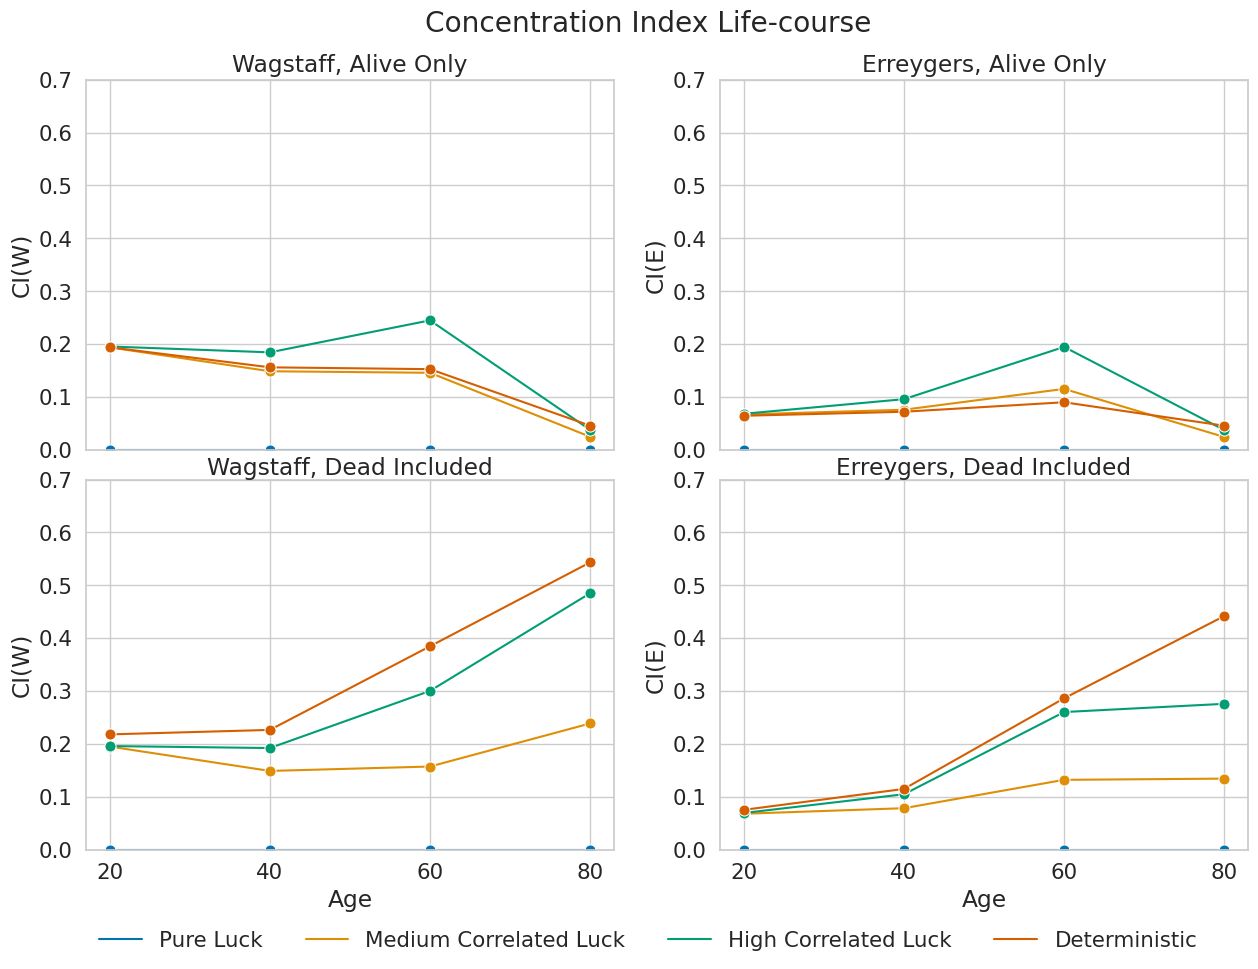

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

plt.setp(axs, xticks=[20,40,60,80], yticks=np.arange(0, 0.8, 0.1), ylim=(0,0.7))

for i, (method, analysis) in enumerate([('W', 'Alive only'), ('E', 'Alive only'), ('W', 'Dead included'), ('E', 'Dead included')]):
    row, col = np.unravel_index(i, (2, 2))
    sns.lineplot(data=life_course_ci_df[(life_course_ci_df.Method == method) & (life_course_ci_df.Analysis == analysis)], hue='Model', x='variable', y='value', marker='o', ax=axs[row, col], markersize=8)
    axs[row, col].set_xlabel("Age") # , fontsize=12)
    m = "Wagstaff" if method == "W" else "Erreygers"
    if i >= 2:
        axs[row, col].set_title(f"{m}, {analysis.title()}", pad=-16) #, fontsize=14)
        axs[row, col].set_xlabel("Age") #, fontsize=12)
    else:
        axs[row, col].set_title(f"{m}, {analysis.title()}") #, fontsize=14)
        axs[row, col].set_xlabel("")
        axs[row, col].set_xticklabels([])
    axs[row, col].set_ylabel(f"CI({method})") #, fontsize=12)
    legend = axs[row, col].legend()
    axs[row, col].legend().remove()

fig.suptitle("Concentration Index Life-course", y=0.95) #, fontsize=16)
# fig.legend(*axs[0, 0].get_legend_handles_labels(), loc="lower center", bbox_to_anchor=(0.5,-0.03))
fig.legend(labels=[label.rstrip(" Model") for label in axs[0,0].get_legend_handles_labels()[1]], handles=axs[0,0].get_legend_handles_labels()[0], loc="lower center", bbox_to_anchor=(0.5,-0.01), ncol=4, title='').get_frame().set_linewidth(0.0) # , fontsize=12, title_fontsize=12).get_frame().set_linewidth(0.0)
fig.subplots_adjust(hspace=0.08)

fig.savefig("./figures/manuscript_figures/Figure_3.png", dpi=600, bbox_inches='tight')


## Cross-sectional Gini

In [59]:
cross_sectional_gini_df = pd.read_excel(dataset, sheet_name="cross-sectional Gini graph")

In [60]:
cross_sectional_gini_df = cross_sectional_gini_df.iloc[:, 6:]

In [61]:
cross_sectional_gini_df = cross_sectional_gini_df.dropna(how='all').iloc[1:]

In [62]:
cross_sectional_gini_df['Model'] = pd.to_numeric(cross_sectional_gini_df['Unnamed: 6'], errors='coerce')
cross_sectional_gini_df['Method'] = cross_sectional_gini_df['Unnamed: 6'].where(cross_sectional_gini_df['Model'].isna())

In [63]:
cross_sectional_gini_df = cross_sectional_gini_df.drop(columns='Unnamed: 6')

In [64]:
cross_sectional_gini_df['Method'] = cross_sectional_gini_df.Method.fillna(method='ffill')

In [65]:
cross_sectional_gini_df = cross_sectional_gini_df.rename(columns={'Unnamed: 7': 'Cross-sectional', 'Unnamed: 8': 'Zombie, dead included'})

In [66]:
cross_sectional_gini_df = cross_sectional_gini_df[cross_sectional_gini_df.Model.isna() == False].copy()

In [67]:
cross_sectional_gini_df['Model'] = cross_sectional_gini_df.Model.replace(name_replacement)

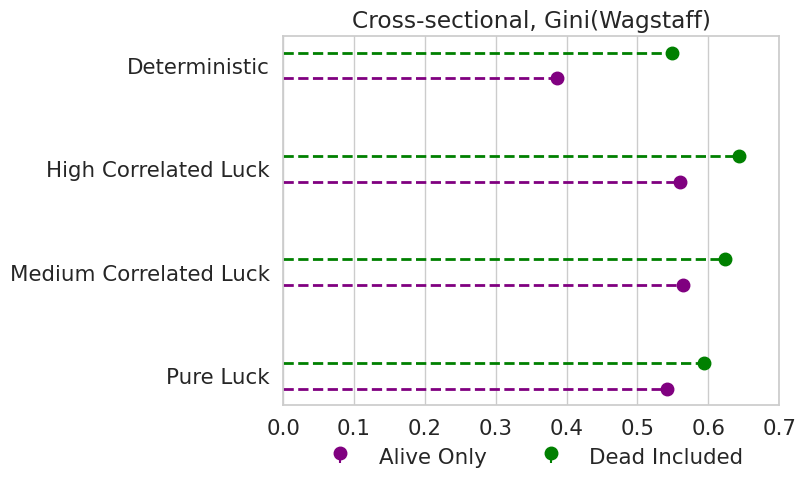

In [68]:
stem1 = plt.stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Wagstaff']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = plt.stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Wagstaff']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

plt.xlim(0, 0.7)
plt.legend(labels=['Alive Only', 'Dead Included'], loc='upper right', bbox_to_anchor=(1, 0.9))

plt.yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck', 'Medium Correlated Luck', 'High Correlated Luck', 'Deterministic'])
plt.title("Cross-sectional, Gini(Wagstaff)")

plt.grid(visible=False, axis='y')

plt.legend(labels=['Alive Only', 'Dead Included'], loc='lower center', bbox_to_anchor=(0.5, -0.22), ncol=2).get_frame().set_linewidth(0.0)


Text(0.5, 1.0, 'Cross-sectional, Gini(E)')

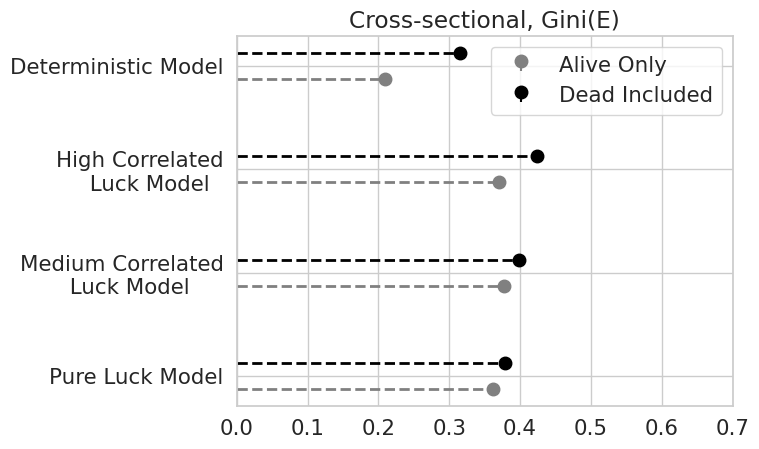

In [69]:
stem1 = plt.stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Erreygers']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = plt.stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Erreygers']['Zombie, dead included'], linefmt='--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='black', markersize=9)
plt.setp(stem2[1], color='black', linewidth=2)

plt.setp(stem1[0], color='gray', markersize=9)
plt.setp(stem1[1], color='gray', linewidth=2)

plt.xlim(0, 0.7)
plt.legend(labels=['Alive Only', 'Dead Included'], loc='upper right')

plt.yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
plt.title("Cross-sectional, Gini(E)")

In [70]:
sns.set_context("notebook", font_scale=1.6)

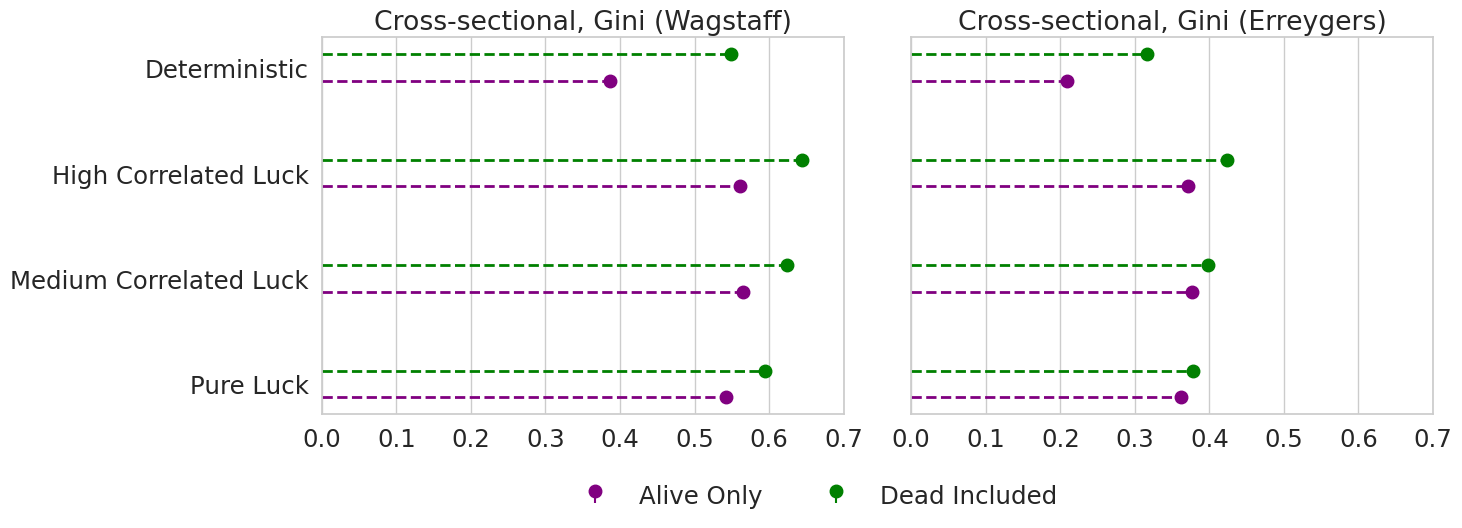

In [71]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

stem1 = axs[0].stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Wagstaff']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[0].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Wagstaff']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[0].set_xlim(0, 0.7)
axs[0].legend(labels=['Alive Only', 'Dead Included'], loc='upper right', bbox_to_anchor=(1, 0.9)).remove()

axs[0].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck', 'Medium Correlated Luck', 'High Correlated Luck', 'Deterministic'])
axs[0].set_title("Cross-sectional, Gini (Wagstaff)")

stem1 = axs[1].stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Erreygers']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[1].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Erreygers']['Zombie, dead included'], linefmt='--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[1].set_xlim(0, 0.7)
axs[1].legend(labels=['Alive Only', 'Dead Included'], loc='upper right').remove()

# axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=[])
axs[1].set_title("Cross-sectional, Gini (Erreygers)")

axs[0].grid(visible=False, axis='y')
axs[1].grid(visible=False, axis='y')

fig.legend(labels=['Alive Only', 'Dead Included'], loc='lower center', bbox_to_anchor=(0.555, -0.1), ncol=2).get_frame().set_linewidth(0.0)

fig.tight_layout()

## % Dot-charts

Text(0.5, 1.0, '% Below Health Score 0.5')

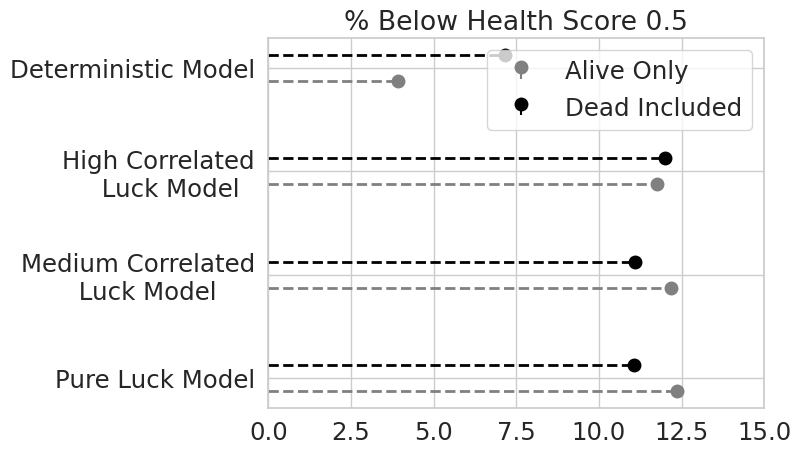

In [72]:
stem1 = plt.stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == '% below 0.5 ']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = plt.stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == '% below 0.5 ']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='black', markersize=9)
plt.setp(stem2[1], color='black', linewidth=2)

plt.setp(stem1[0], color='gray', markersize=9)
plt.setp(stem1[1], color='gray', linewidth=2)

plt.xlim(0, 15)
plt.legend(labels=['Alive Only', 'Dead Included'], loc='upper right')

plt.yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
plt.title("% Below Health Score 0.5")

(0.0, 15.0)

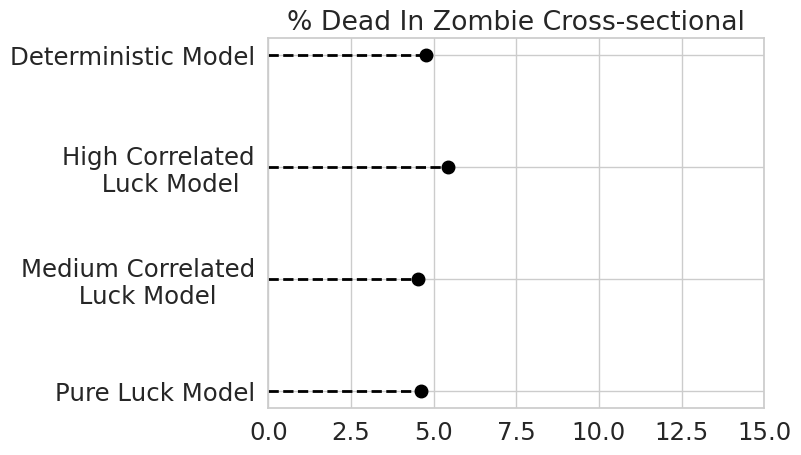

In [73]:
stem = plt.stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == '% dead, Zombie']['Cross-sectional'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem[0], color='black', markersize=9)
plt.setp(stem[1], color='black', linewidth=2)

plt.yticks(ticks=[0, 1, 2, 3], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
plt.title("% Dead In Zombie Cross-sectional")
plt.xlim(0, 15)


In [74]:
sns.set_context("notebook", font_scale=1.5)

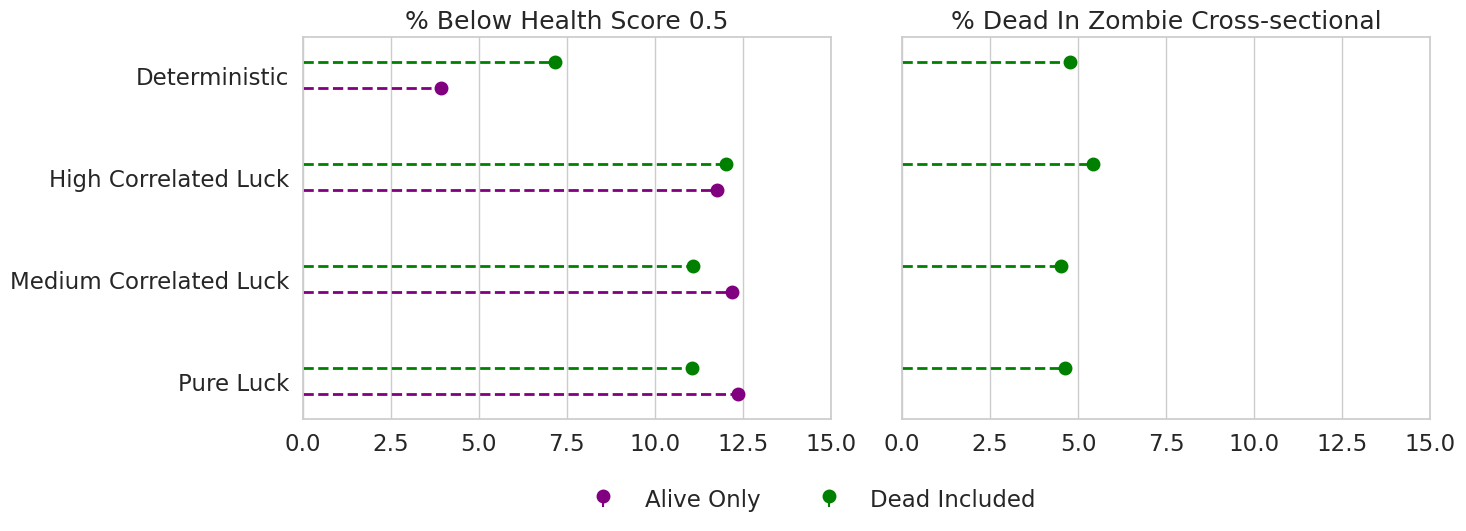

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

stem1 = axs[0].stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == '% below 0.5 ']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[0].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == '% below 0.5 ']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[0].set_xlim(0, 15)
axs[0].set_ylim(-0.25, 3.5)
axs[0].legend(labels=['Alive Only', 'Dead Included'], loc='upper right').remove()

axs[0].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck', 'Medium Correlated Luck', 'High Correlated Luck', 'Deterministic'])
axs[0].set_title("% Below Health Score 0.5")

stem = axs[1].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == '% dead, Zombie']['Cross-sectional'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem[0], color='green', markersize=9)
plt.setp(stem[1], color='green', linewidth=2)

# axs[1].set_yticks(ticks=[0, 1, 2, 3], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=[])
axs[1].set_ylim(-0.25, 3.5)
axs[1].set_title("% Dead In Zombie Cross-sectional")
axs[1].set_xlim(0, 15)

axs[0].grid(visible=False, axis='y')
axs[1].grid(visible=False, axis='y')

fig.legend(labels=['Alive Only', 'Dead Included'], loc='lower center', bbox_to_anchor=(0.55, -0.1), ncol=2).get_frame().set_linewidth(0.0)

fig.tight_layout()

fig.savefig("./figures/appendix_figures/Appendix_10.png", dpi=600, bbox_inches='tight')

## Cross-sectional Concentration Index

In [76]:
cross_sectional_ci_df = pd.read_excel(dataset, sheet_name="cross-sectional CI graph")

In [77]:
cross_sectional_ci_df = cross_sectional_ci_df.iloc[:, 6:]

In [78]:
cross_sectional_ci_df = cross_sectional_ci_df.dropna(how='all').iloc[1:]

In [79]:
cross_sectional_ci_df['Model'] = pd.to_numeric(cross_sectional_ci_df['Unnamed: 6'], errors='coerce')
cross_sectional_ci_df['Method'] = cross_sectional_ci_df['Unnamed: 6'].where(cross_sectional_ci_df['Model'].isna())

In [80]:
cross_sectional_ci_df = cross_sectional_ci_df.rename(columns={'Unnamed: 7': 'Cross-sectional', 'Unnamed: 8': 'Zombie, dead included'})

In [81]:
cross_sectional_ci_df = cross_sectional_ci_df.drop(columns='Unnamed: 6')

In [82]:
cross_sectional_ci_df['Method'] = cross_sectional_ci_df.Method.fillna(method='ffill')

In [83]:
cross_sectional_ci_df = cross_sectional_ci_df[cross_sectional_ci_df.Model.isna() == False].copy()

In [84]:
cross_sectional_ci_df['Model'] = cross_sectional_ci_df.Model.replace(name_replacement)

In [85]:
cross_sectional_ci_df

,Cross-sectional,"Zombie, dead included",Model,Method
7,0,0,Pure Luck Model,Wagstaff
8,0.092758,0.151533,Medium Correlated Luck Model,Wagstaff
9,0.13158,0.228601,High Correlated Luck Model,Wagstaff
10,0.063323,0.277977,Deterministic Model,Wagstaff
16,0,0,Pure Luck Model,Erreygers
17,0.061991,0.096749,Medium Correlated Luck Model,Erreygers
18,0.087057,0.150239,High Correlated Luck Model,Erreygers
19,0.034252,0.159939,Deterministic Model,Erreygers


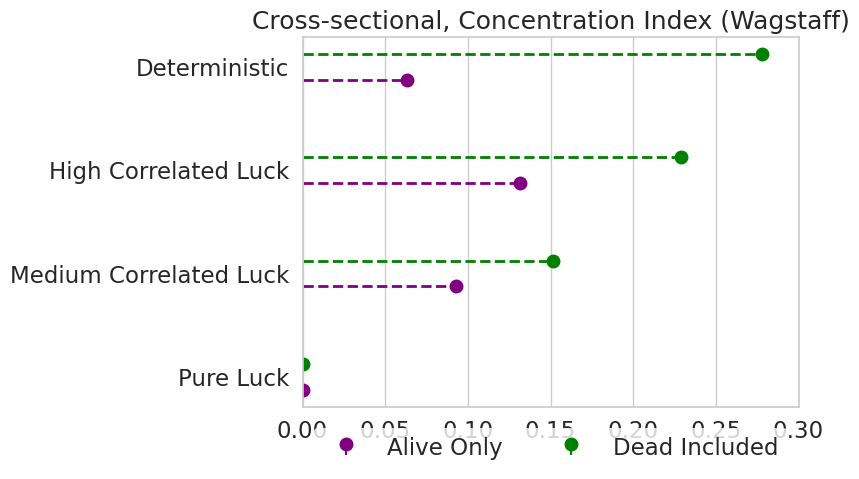

In [86]:
stem1 = plt.stem(cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Wagstaff']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = plt.stem([0.25, 1.25, 2.25, 3.25], cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Wagstaff']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

plt.xlim(0, 0.3)
# plt.legend(labels=['Alive Only', 'Dead Included'], loc='upper right', bbox_to_anchor=(1, 0.9))

plt.yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck', 'Medium Correlated Luck', 'High Correlated Luck', 'Deterministic'])
plt.title("Cross-sectional, Concentration Index (Wagstaff)")

plt.grid(visible=False, axis='y')

plt.legend(labels=['Alive Only', 'Dead Included'], loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2).get_frame().set_linewidth(0.0)

Text(0.5, 1.0, 'Cross-sectional, Concentration Index (E)')

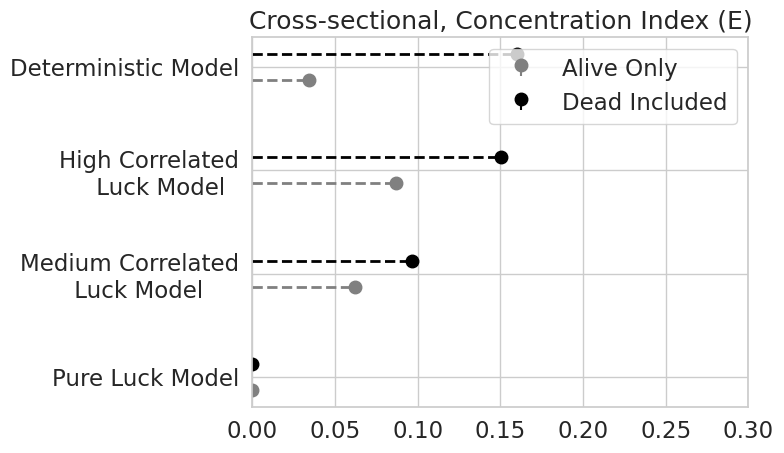

In [87]:
stem1 = plt.stem(cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Erreygers']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = plt.stem([0.25, 1.25, 2.25, 3.25], cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Erreygers']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='black', markersize=9)
plt.setp(stem2[1], color='black', linewidth=2)

plt.setp(stem1[0], color='gray', markersize=9)
plt.setp(stem1[1], color='gray', linewidth=2)

plt.xlim(0, 0.3)
plt.legend(labels=['Alive Only', 'Dead Included'], loc='upper right')

plt.yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
plt.title("Cross-sectional, Concentration Index (E)")

In [88]:
sns.set_context("notebook", font_scale=1.4)

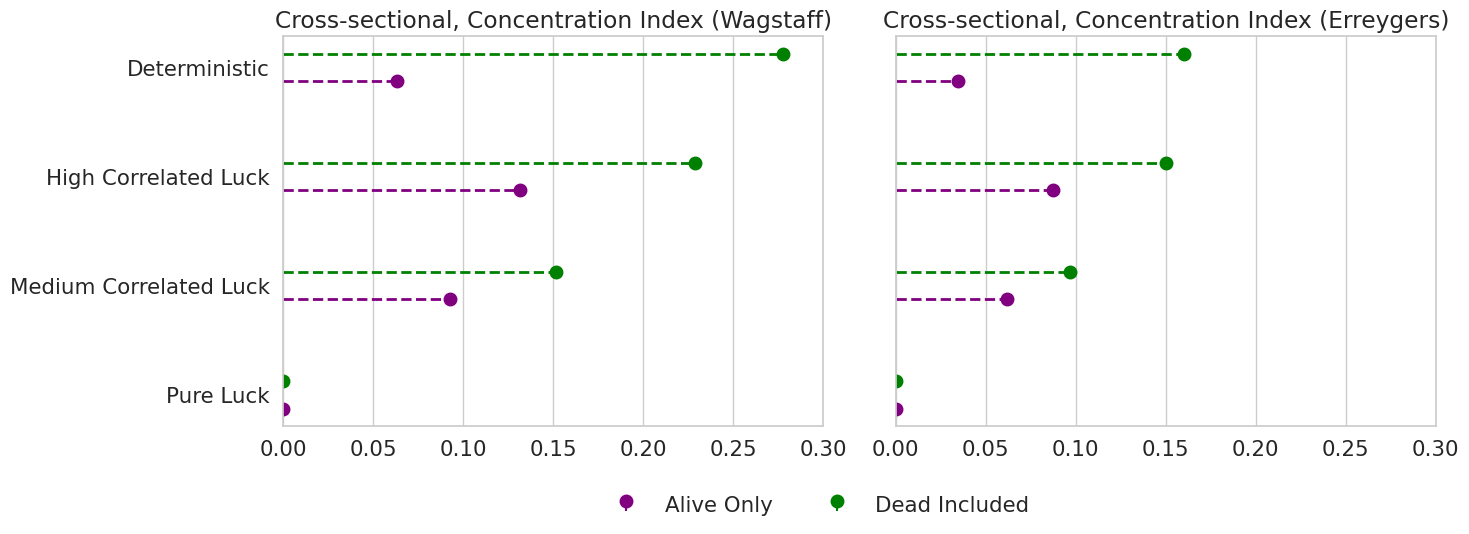

In [89]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

stem1 = axs[0].stem(cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Wagstaff']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[0].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Wagstaff']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[0].set_xlim(0, 0.3)
# axs[0].legend(labels=['Alive Only', 'Dead Included'], loc='upper right', bbox_to_anchor=(1, 0.9))

axs[0].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck', 'Medium Correlated Luck', 'High Correlated Luck', 'Deterministic']) #, fontsize=12)
axs[0].set_title("Cross-sectional, Concentration Index (Wagstaff)") #, fontsize=14)

stem1 = axs[1].stem(cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Erreygers']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[1].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Erreygers']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[1].set_xlim(0, 0.3)
axs[1].legend(labels=['Alive Only', 'Dead Included'], loc='upper right').remove()

# axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=[])
axs[1].set_title("Cross-sectional, Concentration Index (Erreygers)") # , fontsize=14)

axs[0].grid(visible=False, axis='y')
axs[1].grid(visible=False, axis='y')

fig.legend(labels=['Alive Only', 'Dead Included'], loc='lower center', bbox_to_anchor=(0.555, -0.1), ncol=2).get_frame().set_linewidth(0.0)

fig.tight_layout()

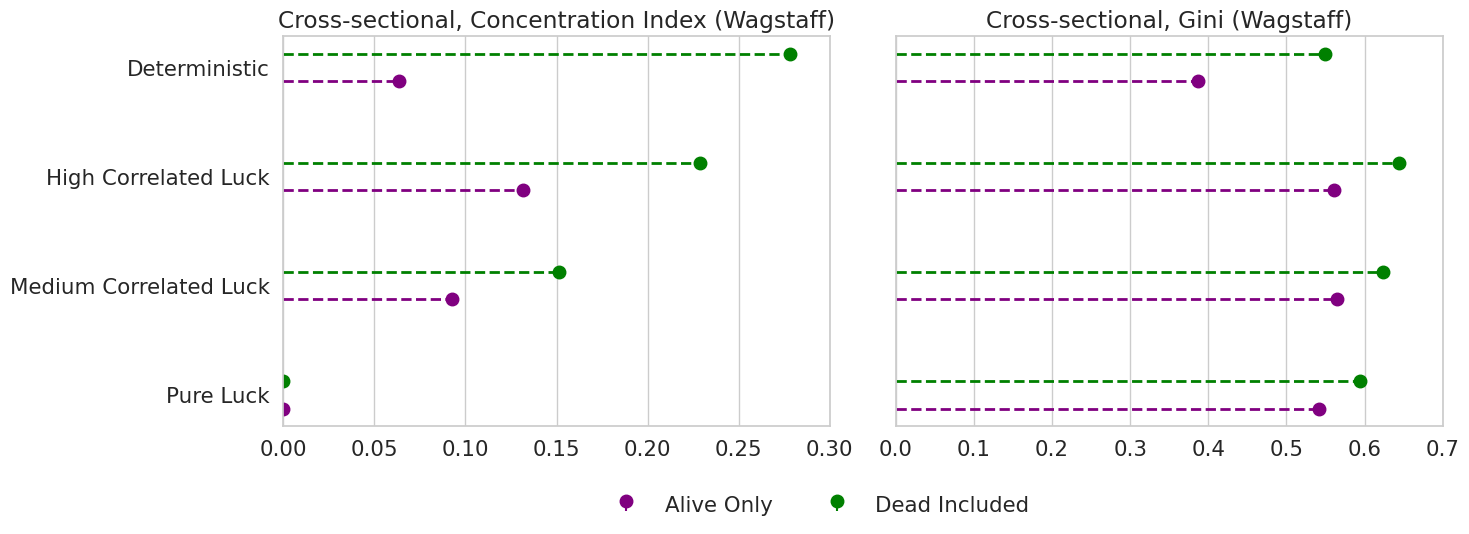

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

stem1 = axs[0].stem(cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Wagstaff']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[0].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Wagstaff']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[0].set_xlim(0, 0.3)
# axs[0].legend(labels=['Alive Only', 'Dead Included'], loc='upper right', bbox_to_anchor=(1, 0.9))

axs[0].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck', 'Medium Correlated Luck', 'High Correlated Luck', 'Deterministic']) #, fontsize=12)
axs[0].set_title("Cross-sectional, Concentration Index (Wagstaff)") #, fontsize=14)

stem1 = axs[1].stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Wagstaff']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[1].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Wagstaff']['Zombie, dead included'], linefmt='--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[1].set_xlim(0, 0.7)
axs[1].legend(labels=['Alive Only', 'Dead Included'], loc='upper right').remove()

# axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=[])
axs[1].set_title("Cross-sectional, Gini (Wagstaff)")

axs[0].grid(visible=False, axis='y')
axs[1].grid(visible=False, axis='y')

fig.legend(labels=['Alive Only', 'Dead Included'], loc='lower center', bbox_to_anchor=(0.555, -0.1), ncol=2).get_frame().set_linewidth(0.0)

fig.tight_layout()

fig.savefig("./figures/manuscript_figures/Figure_5.png", dpi=600, bbox_inches='tight')

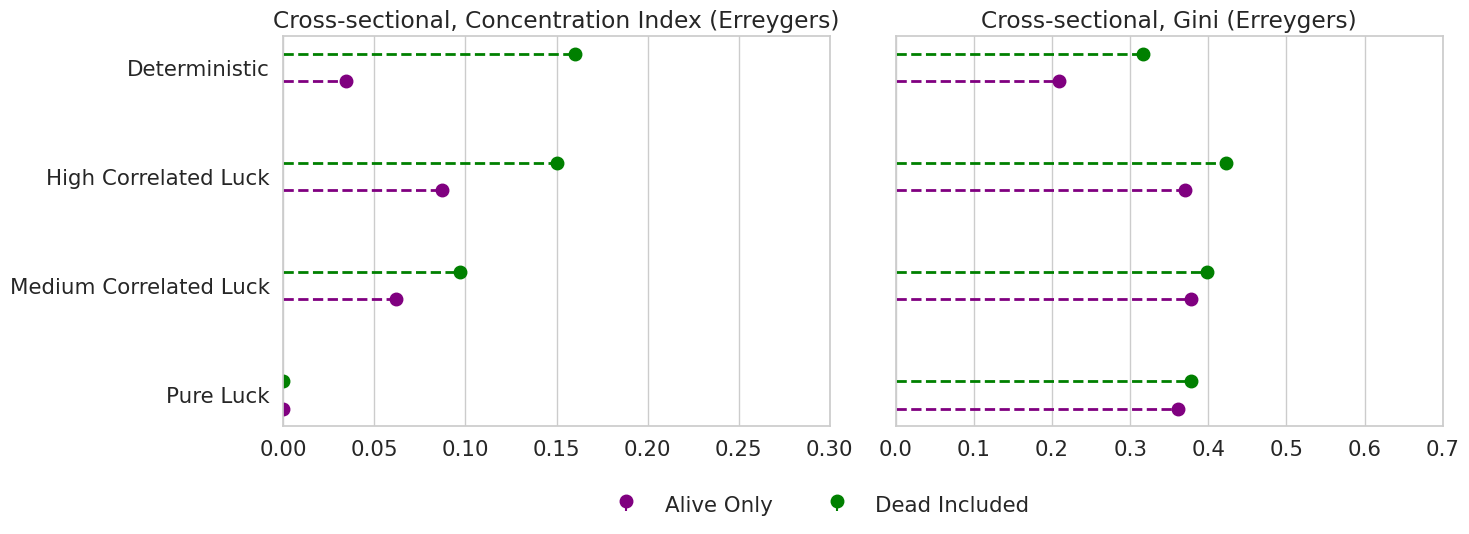

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

stem1 = axs[0].stem(cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Erreygers']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[0].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Erreygers']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[0].set_xlim(0, 0.3)
# axs[0].legend(labels=['Alive Only', 'Dead Included'], loc='upper right', bbox_to_anchor=(1, 0.9))

axs[0].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck', 'Medium Correlated Luck', 'High Correlated Luck', 'Deterministic']) #, fontsize=12)
axs[0].set_title("Cross-sectional, Concentration Index (Erreygers)") #, fontsize=14)

stem1 = axs[1].stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Erreygers']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[1].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Erreygers']['Zombie, dead included'], linefmt='--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='green', markersize=9)
plt.setp(stem2[1], color='green', linewidth=2)

plt.setp(stem1[0], color='purple', markersize=9)
plt.setp(stem1[1], color='purple', linewidth=2)

axs[1].set_xlim(0, 0.7)
axs[1].legend(labels=['Alive Only', 'Dead Included'], loc='upper right').remove()

# axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=[])
axs[1].set_title("Cross-sectional, Gini (Erreygers)")

axs[0].grid(visible=False, axis='y')
axs[1].grid(visible=False, axis='y')

fig.legend(labels=['Alive Only', 'Dead Included'], loc='lower center', bbox_to_anchor=(0.555, -0.1), ncol=2).get_frame().set_linewidth(0.0)

fig.tight_layout()

fig.savefig("./figures/appendix_figures/Appendix_9.png", dpi=600, bbox_inches='tight')

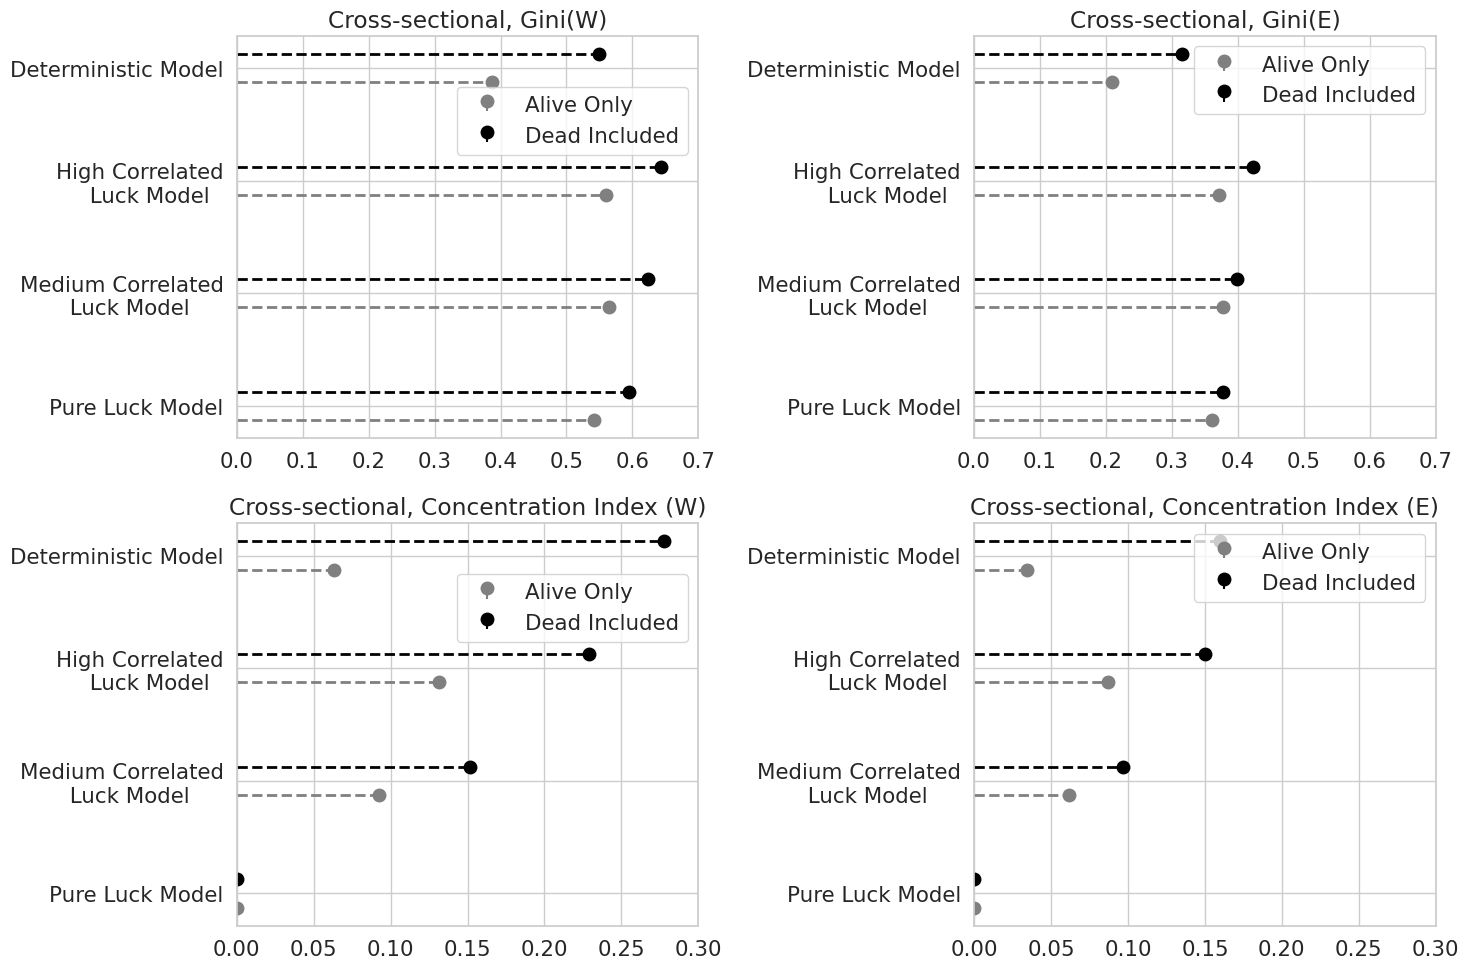

In [92]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

stem1 = axs[0, 0].stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Wagstaff']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[0, 0].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Wagstaff']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='black', markersize=9)
plt.setp(stem2[1], color='black', linewidth=2)

plt.setp(stem1[0], color='gray', markersize=9)
plt.setp(stem1[1], color='gray', linewidth=2)

axs[0, 0].set_xlim(0, 0.7)
axs[0, 0].legend(labels=['Alive Only', 'Dead Included'], loc='upper right', bbox_to_anchor=(1, 0.9))

axs[0, 0].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[0, 0].set_title("Cross-sectional, Gini(W)")

stem1 = axs[0, 1].stem(cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Erreygers']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[0, 1].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_gini_df[cross_sectional_gini_df.Method == 'Erreygers']['Zombie, dead included'], linefmt='--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='black', markersize=9)
plt.setp(stem2[1], color='black', linewidth=2)

plt.setp(stem1[0], color='gray', markersize=9)
plt.setp(stem1[1], color='gray', linewidth=2)

axs[0, 1].set_xlim(0, 0.7)
axs[0, 1].legend(labels=['Alive Only', 'Dead Included'], loc='upper right')

axs[0, 1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[0, 1].set_title("Cross-sectional, Gini(E)")

fig.tight_layout()

stem1 = axs[1, 0].stem(cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Wagstaff']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[1, 0].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Wagstaff']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='black', markersize=9)
plt.setp(stem2[1], color='black', linewidth=2)

plt.setp(stem1[0], color='gray', markersize=9)
plt.setp(stem1[1], color='gray', linewidth=2)

axs[1, 0].set_xlim(0, 0.3)
axs[1, 0].legend(labels=['Alive Only', 'Dead Included'], loc='upper right', bbox_to_anchor=(1, 0.9))

axs[1, 0].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[1, 0].set_title("Cross-sectional, Concentration Index (W)")

stem1 = axs[1, 1].stem(cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Erreygers']['Cross-sectional'], linefmt='--', orientation='horizontal', basefmt=' ')
stem2 = axs[1, 1].stem([0.25, 1.25, 2.25, 3.25], cross_sectional_ci_df[cross_sectional_ci_df.Method == 'Erreygers']['Zombie, dead included'], linefmt='g--', orientation='horizontal', basefmt=' ')

plt.setp(stem2[0], color='black', markersize=9)
plt.setp(stem2[1], color='black', linewidth=2)

plt.setp(stem1[0], color='gray', markersize=9)
plt.setp(stem1[1], color='gray', linewidth=2)

axs[1, 1].set_xlim(0, 0.3)
axs[1, 1].legend(labels=['Alive Only', 'Dead Included'], loc='upper right')

axs[1, 1].set_yticks(ticks=[0.125, 1.125, 2.125, 3.125], labels=['Pure Luck Model', 'Medium Correlated\n Luck Model     ', 'High Correlated\n Luck Model  ', 'Deterministic Model'])
axs[1, 1].set_title("Cross-sectional, Concentration Index (E)")

fig.tight_layout()